In [1]:
import argparse
import os

import numpy as np
from cohlib.bcn import gen_bcn_params, sample_bcn_time_obs
from cohlib.mvcn import gen_random_mvcn_params, sample_mvcn_time_obs
from numpy.fft import rfft, rfftfreq
from cohlib.estimation import thr_coherence, estimate_coherence
from cohlib.sim import spikes_from_xns
from cohlib.alg.transform import construct_real_idft

from cohlib.utils import pickle_save, get_dcval

In [179]:
def construct_latent_and_sample(sample_length, L, fs, K, dc_vals):
    T = sample_length/fs
    Gamma, freqs = gen_random_mvcn_params(T, fs, K)
    n_freqs = Gamma.shape[0]

    # diagonal elements of Gamma for high-coherence frequency
    val1 = 1500
    val2 = 1500

    
    q = 0.1 # scaling for off-diagonal of low-coherence frequencies

    # here we're choosing a single frequency (10) to isolate and set Gamma to have high coherence
    # we let the the rest of the frequencies have low coherence by: 
    low_coh = np.sqrt(q)*np.random.randn(n_freqs-1) + 1j*np.sqrt(q)*np.random.randn(n_freqs-1)

    Gamma[freqs!=10,0,1] = 0.1*low_coh
    Gamma[freqs!=10,1,0] = 0.1*low_coh.conj()

    Gamma[freqs==10,0,0] = val1+0*1j
    Gamma[freqs==10,1,1] = val2+0*1j

    # construct high coherence for target freq
    val = np.sqrt(val1)*np.sqrt(val2)
    init = np.abs(Gamma[freqs==10,1,0])
    scale = val/init
    Gamma[freqs==10,1,0] *= scale*0.92
    Gamma[freqs==10,0,1] = Gamma[freqs==10,1,0].conj()



    # Draw observations from mvcn (in time domain) 

    # TODO refactor for mvcn
    xs, vs, zs = sample_mvcn_time_obs(Gamma, L, freqs, Wv, dc_vals, return_all=True)

    latent = dict(Gamma=Gamma, xs=xs, vs=vs, zs=zs)
    meta = dict(freqs=freqs)

    return latent, meta

In [ ]:
# variables we would like to be able to set through CLI:
def run():
    parser = argparse.ArgumentParser()
    parser.add_argument('sample_length', type=int, default=500)
    parser.add_argument('L', type=int, default=30)
    parser.add_argument('K', type=int, default=2)
    parser.add_argument('C', type=int, default=25)
    parser.add_argument('mu', nargs='?', type=float, default=-3.5)
    parser.add_argument('seed', nargs='?', type=int, default=8)
    args = parser.parse_args()

    sample_length = args.sample_length # sample length (was slen in notebook)
    seed = args.seed
    L = args.L
    C = args.C
    K = args.K
    mu = args.mu


    print(f"Generating Synthetic SGC data with L: {L}, K: {K}, sample_length: {sample_length}, C: {C}, mu: {mu}, seed: {seed}")

    save_path = f'saved/synthetic_data/simple_synthetic_{L}_{sample_length}_{C}_{mu}_{seed}'

    fs = 1000

    latent, meta = construct_latent_distribution(sample_length, L, fs)

    for k in range(K):
        pass
    # no edits below

    xns = latent['xns']
    xys = latent['xys']

    meta['L'] = L
    meta['C'] = C
    meta['seed'] = seed
    meta['sample_length'] = sample_length
    meta['fs'] = 1000


    pp_params = get_rep_pp_params(mu, beta, C, swap=False)


    observed = dict(spikes=spikes, mu=mu)

    save_dict = dict(latent=latent, meta=meta, observed=observed)

    pickle_save(save_dict, save_path)


if __name__ == "__main__":
    run()

In [180]:
Gamma[10,0,1]

(-0.029221531944284364-0.024546962776937936j)

In [181]:
def sample_spike_observations(xs, C, axis):
    # func = _sample_spike_vec_func(x, C, )
    
    # np.apply_along_axis(_sample_spike_vec, )
    pass


def _sample_spike_vec_func(x, C):
    def sample_func(x):
        # for i in x:
        pass
    pass

            
            # np.newaxis

def logistic(x):
    return 1/(1+np.exp(-x))

In [182]:
mu = -3.5
K = 2
sample_length = 1000
T = sample_length/1e-3
J = int(sample_length/2)
fs = 1000
L = 20


dc = np.array([get_dcval(mu, J) for k in range(K)])
Wv = construct_real_idft(sample_length, J, fs)
latent, meta = construct_latent_and_sample(sample_length, L, fs, K, dc)


In [183]:
Gamma = latent['Gamma']
xs = latent['xs']
vs = latent['vs']
zs = latent['zs']
freqs = meta['freqs']
lams = np.apply_along_axis(logistic, 2, xs)

In [193]:
dc = np.array([get_dcval(mu, J) for k in range(K)])
latent, meta = construct_latent_and_sample(sample_length, L, fs, K, dc)
xs = latent['xs']

lams = np.apply_along_axis(logistic, 2, xs)

In [194]:
lams.shape

(20, 2, 1000)

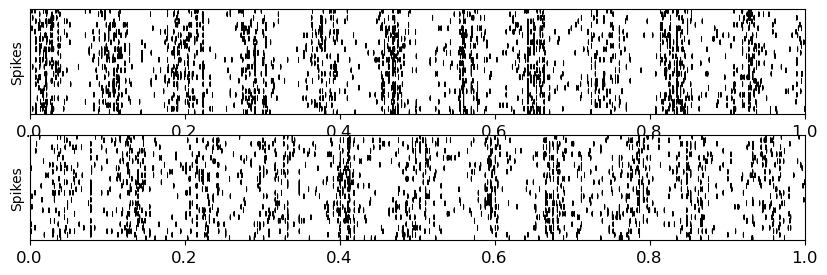

In [188]:
import matplotlib.pyplot as plt
x = xs[0,0,:]
v = vs[0,0,:]
z = zs[0,0,:]

C = 30
# for i in range(K):
def _c_sample_func(C):
    def func(x):
        reps = np.tile(x, C).reshape(C,-1)
        samples = np.random.binomial(1, reps)
        return samples
    return func

def sample_spikes_from_xs(lams, C, group_axis=1):
    sampler = _c_sample_func(C)
    samples = np.apply_along_axis(sampler, 1, lams)
    return samples



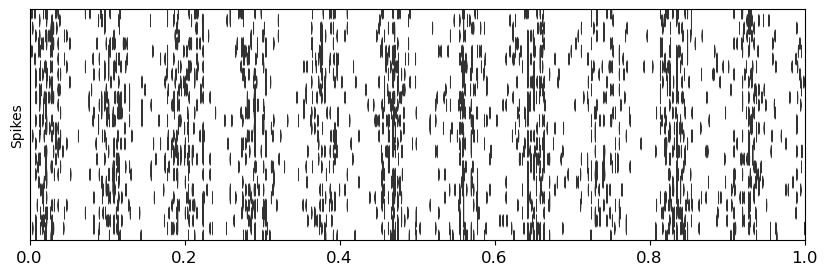

In [191]:
import matplotlib.pyplot as plt
test[0,:,:,:].sum()
fig, ax = plt.subplots(figsize=(10,3))
draw_raster_single(test[0,:,0,:], [0,1], ax=ax)

In [190]:
import matplotlib
def draw_raster_single(spike_mat, trange, contrast=0.1, ax=None, ylabel=True,
                       origin='lower', **kwargs):
    ax = ax or plt.gca()
    contrast_scale = contrast
    
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'gray_r_a', [(0., 0., 0., 0.),  (0., 0., 0., 1.)])
    
    kwargs.setdefault('aspect', 'auto')
    kwargs.setdefault('cmap', cmap)
    kwargs.setdefault('interpolation', None)
    kwargs.setdefault('extent', (trange[0], trange[-1], 0., spike_mat.shape[0]))
    
    ymin = 0
    ymax = spike_mat.shape[0]
    ax.set_ylim([ymin, ymax])
    ax.set_ylabel('Spikes')
    ax.get_yaxis().set_ticks([])
    ax.tick_params(axis='x', which='major', labelsize=12)
    
    alpha = 0.2
    n_units = spike_mat.shape[0]
    ax.axhspan(0, n_units + 1, facecolor='white', alpha=alpha) #

    spikeraster = ax.imshow(spike_mat, origin=origin, **kwargs)
    spikeraster.set_clim(0., np.max(spike_mat) * contrast_scale)
    
    return spikeraster
